In [89]:
#pip install pmdarima

# State Space Model Using ARIMA Method
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

### Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.

In [217]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from datapackage import Package

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

matplotlib.rcParams['figure.figsize'] = [8, 3]
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2


In [121]:
# Read in data
month = pd.read_excel('/Users/jasonrobinson/Documents/Projects/U.S. 10-yr-Bond.xls', parse_dates=['Date'], index_col='Date')
print(month.shape)
month.head()

(808, 1)


,Rate
Date,
1953-04-30,2.83
1953-05-31,3.05
1953-06-30,3.11
1953-07-31,2.93
1953-08-31,2.95



### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

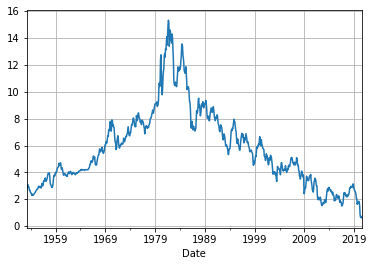

In [87]:
month['Rate'].plot(grid=True);

In [168]:
month['Rate']

Date
1953-04-30    2.83
1953-05-31    3.05
1953-06-30    3.11
1953-07-31    2.93
1953-08-31    2.95
              ... 
2020-03-31    0.87
2020-04-30    0.66
2020-05-31    0.67
2020-06-30    0.73
2020-07-31    0.62
Name: Rate, Length: 808, dtype: float64

In [91]:
month = month[month['Rate']>'2000']
month

KeyError: 'Date'

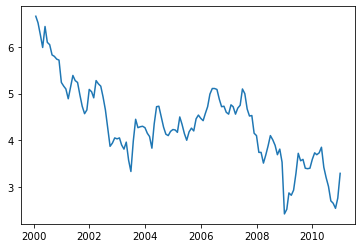

In [93]:
# 10-year period (2000-2010)
plt.plot(month['2000':'2010']['Rate']);

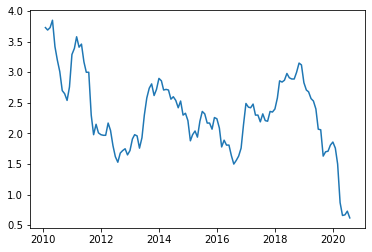

In [137]:
# 10-year period (2010-2020)
plt.plot(month['2010':'2020']['Rate']);

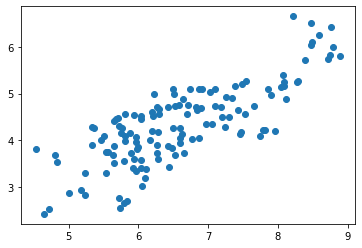

In [95]:
# Comparing 2 previous decades
plt.scatter(month['1990':'2000'][['Rate']], month['2000':'2010'][['Rate']]);

In [97]:
month['1990':'2000'][['Rate']].head()

,Rate
Date,
1990-01-31,8.21
1990-02-28,8.47
1990-03-31,8.59
1990-04-30,8.79
1990-05-31,8.76


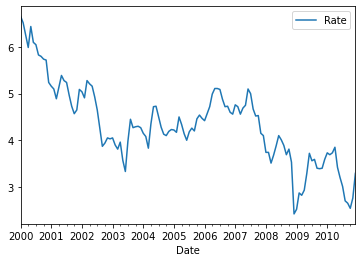

In [102]:
month['2000':'2010'].plot();

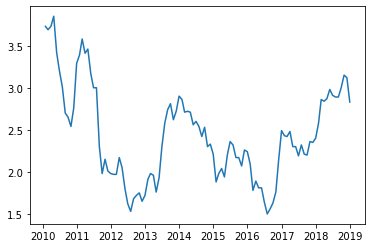

In [100]:
plt.plot(month['2010':'2018'][['Rate']]);


### Test for Stationarity

For us to be capable of applying an **ARIMA** method, we will first need to add stationarity. First let's confirm that our time series is not stationary. A few methods exist for this, but we will use the **KPSS** method.



In [200]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month['Rate'])

(0.7319408103900956, True)

In [201]:
from statsmodels.tsa.stattools import adfuller


def adf_test(month):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(month, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [202]:
adf_test(month)

Results of Dickey-Fuller Test:
Test Statistic                  -0.860881
p-value                          0.800582
#Lags Used                      21.000000
Number of Observations Used    786.000000
Critical Value (1%)             -3.438697
Critical Value (5%)             -2.865224
Critical Value (10%)            -2.568732
dtype: float64


In [203]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [204]:
kpss_test(month)

Results of KPSS Test:
Test Statistic            0.928395
p-value                   0.010000
Lags Used                18.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


In [198]:
# Reject the null hypothesis - test statistic actual pvalue smaller
#sm.tsa.stattools.kpss(month, regression='ct')

(0.8087622620069987,
 0.01,
 21,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

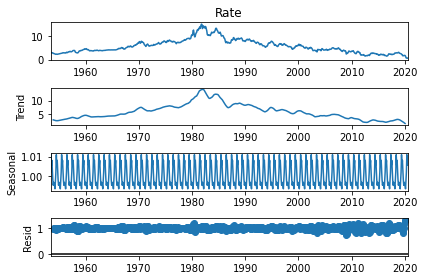

In [190]:
from statsmodels.tsa.seasonal import seasonal_decompose
# ETS plot

seas_dcomp = seasonal_decompose(month['Rate'],period=12,model='multiplicative')

seas_dcomp.plot();


### Make Series Stationary


In [205]:
#Transform the data from non-statinary to stationary
month_log = np.sqrt(month['Rate'])
month_diff = month_log.diff().dropna()

In [206]:
# Check for stationarity
result = adfuller(month_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -14.931696
p-value: 0.000000
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [208]:
result_kpss_ct_log=kpss(month_diff,regression="ct")
print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
print('p-value: %f' %result_kpss_ct_log[1])
print('Critical values:')
for key, value in result_kpss_ct_log[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.030000
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


In [235]:
month_new = month['Rate']
month_24 = month_new[777:-7]
month_24.shape

(24,)

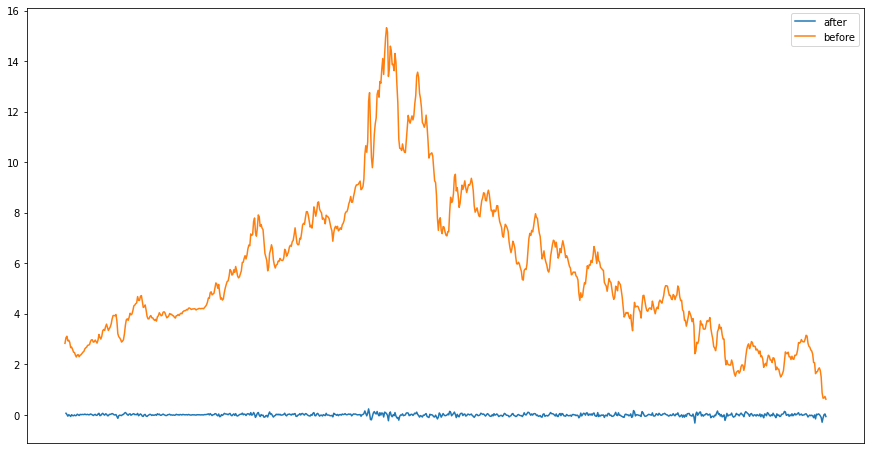

In [238]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month,label="before")
plt.tick_params(
    axis='x',        
    which='both',   
    bottom=False,      
    top=False,        
    labelbottom=False)
plt.legend()
plt.show()

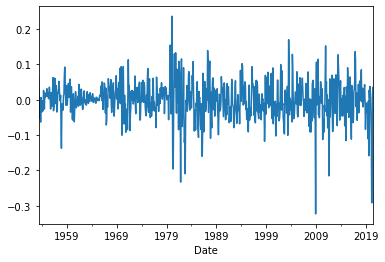

In [239]:
# Closer display
month_diff.plot()
plt.show();


### Auto-ARIMA

In [240]:
# 24-month period
#test = month['Rate'][777:-7]
#test.shape

In [249]:
from pmdarima import auto_arima

month_fit = auto_arima(month_diff,start_p=0, d=1, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 50 )

month_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1573.739, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1845.668, Time=0.64 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1622.663, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1950.460, Time=1.09 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-1988.096, Time=1.92 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=13.74 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.02 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-1949.611, Time=1.46 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-2125.565, Time=2.95 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-2083.160, Time=1.48 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=10.54 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.64 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=-2151.157, Time=4.10 sec
 ARIMA(3,1,0)(2,1,0)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  807
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                1082.578
Date:                            Mon, 04 Jul 2022   AIC                          -2151.157
Time:                                    23:17:02   BIC                          -2118.417
Sample:                                         0   HQIC                         -2138.575
                                            - 807                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3876      0.025    -15.357      0.000      -0.437      -0.338
ar.L2         -0.4610      0.028    -16.542      0.000      -0.516      -0.406
ar.L3         -0.1865      0.032     -5.854      0.000      -0.249      -0.124
ar.S.L12      -0.7702      0.031    -24.567      0.000      -0.832      -0.709
ar.S.L24      -0.5125      0.038    -13.365      0.000      -0.588      -0.437
ar.S.L36      -0.2296      0.034     -6.677      0.000      -0.297      -0.162
sigma2         0.0038      0.000     26.296      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):               103.22
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               3.42   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [262]:
# Split data into train / test sets
train = month_diff.iloc[777:len(month_diff)-12]
test = month_diff.iloc[len(month_diff)-12:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train, 
                order = (2, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97693D+06    |proj g|=  1.07059D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     18      1     0     0   3.804D+02   1.516D+00
  F =   1.5163419013132138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Rate   No. Observations:                   18
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -27.294
Date:                            Mon, 04 Jul 2022   AIC                             68.588
Time:                                    23:31:03   BIC                             65.854
Sample:                                02-28-2018   HQIC                            61.251
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       8.628e-07      0.451   1.91e-06      1.000      -0.884       0.884
ar.L2       4.103e-07      0.179   2.29e-06      1.000      -0.352       0.352
ma.L1         -0.4137      0.519     -0.797      0.426      -1.431       0.604
ar.S.L12    1.027e-14   1.52e-09   6.77e-06      1.000   -2.97e-09    2.97e-09
ar.S.L24     1.04e-14   8.42e-10   1.24e-05      1.000   -1.65e-09    1.65e-09
ma.S.L12   -1.031e-14   1.54e-09  -6.69e-06      1.000   -3.02e-09    3.02e-09
sigma2         0.0002   1.36e-05     11.086      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.96   Prob(JB):                         0.74
Heteroskedasticity (H):               1.59   Skew:                            -0.12
Prob(H) (two-sided):                  0.77   Kurtosis:                         1.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

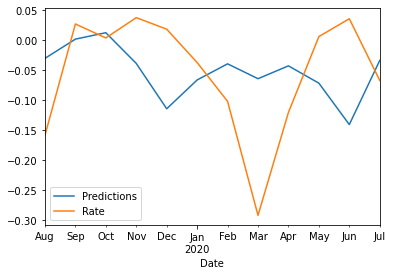

In [263]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

In [265]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse(test, predictions)
mean_squared_error(test, predictions)

0.011804634263135714

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23548D+00    |proj g|=  4.57091D+00


 This problem is unconstrained.



At iterate    5    f= -1.28655D+00    |proj g|=  6.10886D-01

At iterate   10    f= -1.33985D+00    |proj g|=  3.30358D+00

At iterate   15    f= -1.44563D+00    |proj g|=  3.21949D-01

At iterate   20    f= -1.45785D+00    |proj g|=  1.47262D-01

At iterate   25    f= -1.45926D+00    |proj g|=  2.41717D-02

At iterate   30    f= -1.45943D+00    |proj g|=  4.44526D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     48      1     0     0   6.075D-03  -1.459D+00
  F =  -1.4594343385169082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


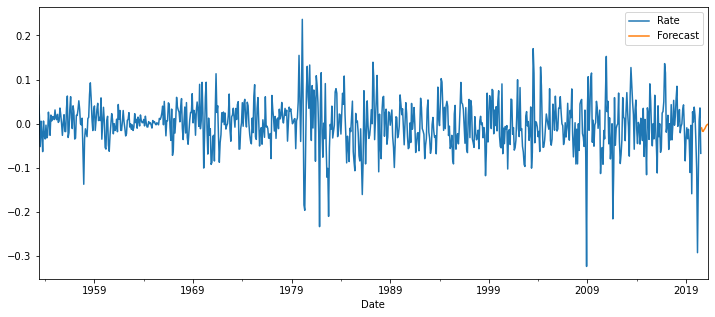

In [266]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 3, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);
